In [20]:
import os
from pandas import *
import numpy as np
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
set_option('display.max_columns', None)


In [21]:
path = "G:/datasets/Loan Prediction"
def load_data(path = path):
    csv_path = os.path.join(path,file_name)
    return read_csv(csv_path)

file_name = "train_ctrUa4K.csv"
data = load_data(path)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [22]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# Visualization

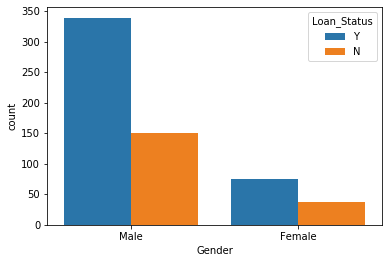

In [23]:
_ = sns.countplot(data = data,x = "Gender",hue = "Loan_Status",saturation = 0.85)


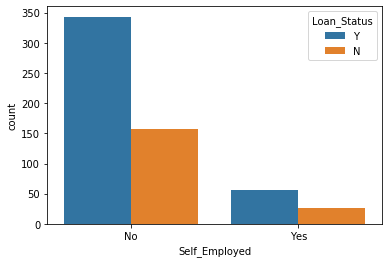

In [24]:
_ = sns.countplot(data = data,x = "Self_Employed",hue = "Loan_Status")

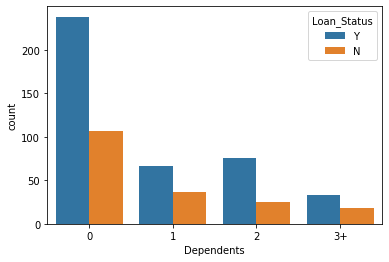

In [25]:
 _ = sns.countplot(data = data,x = "Dependents",hue = "Loan_Status")

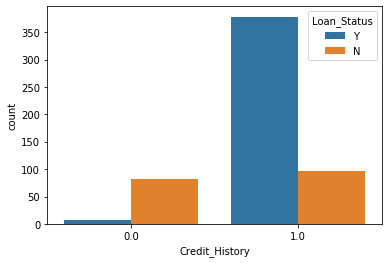

In [26]:
_ = sns.countplot(data = data,x = 'Credit_History',hue = 'Loan_Status')

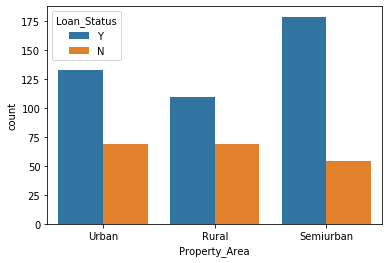

In [27]:
_ = sns.countplot(data = data , x = 'Property_Area',hue = 'Loan_Status')

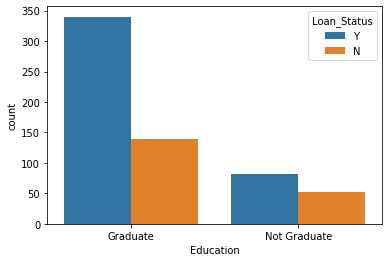

In [28]:
_ = sns.countplot(data = data,x = 'Education',hue = 'Loan_Status')

# Data Preprocessing

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [30]:
def dummy(data,cat_attrib):
    for attr in cat_attrib:
        data = data.merge(get_dummies(data[attr], prefix=attr), left_index=True, right_index=True)
        data.drop(attr,axis=1,inplace=True)
    return data


In [31]:

imputer = KNNImputer(n_neighbors=5
                     , weights="uniform")

In [32]:

def prepare_data(train_data):
    
    train_data = train_data.drop(columns = ["Loan_ID"],axis = 1)
    
    train_data["Credit_History"] = train_data["Credit_History"].replace((1,0) ,('1','0'))
     
   
    

    cat_attrib = [colname for colname in train_data.columns if train_data[colname].dtype == 'object']
    num_attrib = [colname for colname in train_data.columns if train_data[colname].dtype != 'object']

    data_num = train_data.drop(columns = cat_attrib,axis = 1)
    data_cat = train_data.drop(columns = num_attrib , axis = 1)

    data_num_imputed = imputer.fit_transform(data_num)  # 
    data_num_std = DataFrame(StandardScaler().fit_transform(data_num_imputed) , columns = num_attrib)


    data_cat_imputed = DataFrame(SimpleImputer(strategy = 'most_frequent').fit_transform(data_cat),columns = cat_attrib)
    data_cat_dummy = dummy(data_cat_imputed , cat_attrib)

    

    data_prepared = concat([data_num_std,data_cat_dummy],axis = 1)

    return data_prepared  


In [33]:
train_data = data.drop(columns = ["Loan_Status"],axis = 1)

label = data["Loan_Status"]
dict = {'Y':1,'N':0} 
label = label.map(dict)

data_prepared = concat([prepare_data(train_data),label],axis = 1)

data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    float64
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Gender_Female            614 non-null    uint8  
 5   Gender_Male              614 non-null    uint8  
 6   Married_No               614 non-null    uint8  
 7   Married_Yes              614 non-null    uint8  
 8   Dependents_0             614 non-null    uint8  
 9   Dependents_1             614 non-null    uint8  
 10  Dependents_2             614 non-null    uint8  
 11  Dependents_3+            614 non-null    uint8  
 12  Education_Graduate       614 non-null    uint8  
 13  Education_Not Graduate   614 non-null    uint8  
 14  Self_Employed_No         6

In [34]:

%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
#</style>

## Train - Test spliting

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1,test_size = 0.2,random_state = 42)

data_for_split = data_prepared

for train_index,test_index in split.split(data_for_split,data_for_split["Loan_Status"]):
    strat_train_set = data_for_split.loc[train_index]
    strat_test_set = data_for_split.loc[test_index]

    


print(strat_test_set["Loan_Status"].value_counts() / len(strat_test_set)) 
print(strat_train_set["Loan_Status"].value_counts() / len(strat_train_set))


x_train = strat_train_set.drop(columns = ["Loan_Status"])
y_train = strat_train_set["Loan_Status"]
x_test = strat_test_set.drop(columns = ["Loan_Status"])
y_test = strat_test_set["Loan_Status"]

1    0.691057
0    0.308943
Name: Loan_Status, dtype: float64
1    0.686354
0    0.313646
Name: Loan_Status, dtype: float64


## Feature selection

In [36]:

from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier

colname = x_train.columns

xtree = ExtraTreesClassifier()


rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)


def selectkbest(clf , x_train , y_train,k):
    clf.fit(x_train,y_train)
    feature_score = clf.feature_importances_
    feature_dict = {'Features':x_train.columns,'Importance':feature_score}
    feature_df = DataFrame(feature_dict)
    
    sorted_feature_df = feature_df.sort_values('Importance',ascending = False)
    return feature_df,sorted_feature_df.iloc[:k,:]

In [37]:
feature_df , k_best_feature_df = selectkbest(RandomForestClassifier(n_estimators=500, n_jobs=-1) , x_train , y_train,15)

k_best_features = [w for w in k_best_feature_df.Features]
k_best_features

['LoanAmount',
 'ApplicantIncome',
 'Credit_History_1',
 'Credit_History_0',
 'CoapplicantIncome',
 'Loan_Amount_Term',
 'Property_Area_Semiurban',
 'Dependents_0',
 'Property_Area_Rural',
 'Dependents_1',
 'Property_Area_Urban',
 'Education_Graduate',
 'Education_Not Graduate',
 'Married_Yes',
 'Married_No']

In [38]:
x_train = x_train.loc[:,k_best_features]

x_test = x_test.loc[:,k_best_features]

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import f1_score

## Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier 
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(x_train,y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## SVM 

In [42]:
from sklearn.svm import SVC

svclf = SVC()

svclf.fit(x_train,y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## AdaBoost 

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2),n_estimators = 100 , learning_rate = 0.005)

ada_clf.fit(x_train,y_train)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

## Gridsearch

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators' : [3,10,20,40,50,70,100], 'learning_rate' : [0.001,0.005,0.008,0.01,0.07, 0.1,0.5,0.8]}
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2))
#clf.fit(x_train,y_train)

grd_srch = GridSearchCV(clf , param_grid , scoring = 'accuracy',return_train_score = True)


grd_srch.fit(x_train,y_train)

grd_srch.best_params_

{'learning_rate': 0.005, 'n_estimators': 50}

## Accuracy of different classifiers on the test set

In [46]:
models = [("Log Reg",log_reg),('D Tree',tree_clf),('SVC',svclf),("Adaboost",ada_clf),('Grid Search',grd_srch)]

name = []
accuracy = []
conf_mat = []
f1_scr = []
precision = []
for name,model in models :
    y_pred = model.predict(x_test)
    accuracy.append(round(accuracy_score(y_test,y_pred),4)*100)
    f1_scr.append(round(f1_score(y_test,y_pred, average="macro"),4)*100)
    precision.append(round(precision_score(y_test,y_pred),4)*100)
    conf_mat.append(DataFrame(confusion_matrix(y_test,y_pred)).style.set_caption(name))
    

name = [name for name,model in models]
dict = {"Classifier":name,"Accuracy":accuracy,"f1_score":f1_scr,'precision':precision}
result_test = DataFrame(dict)
result_test

,Classifier,Accuracy,f1_score,precision
0,Log Reg,86.18,81.47,84.00
1,D Tree,84.55,78.82,82.35
2,SVC,83.74,77.96,82.18
3,Adaboost,84.55,78.82,82.35
4,Grid Search,84.55,78.82,82.35


In [48]:
for confusion_mat in conf_mat :
    display(confusion_mat)

,0,1
0,22,16
1,1,84


,0,1
0,21,17
1,1,84


,0,1
0,20,18
1,1,84


,0,1
0,20,18
1,1,84


,0,1
0,21,17
1,1,84


,0,1
0,23,15
1,6,79


## Neural Network

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



from tensorflow.keras.optimizers import Adam , RMSprop,SGD





In [ ]:
model = keras.models.Sequential([keras.layers.Input(shape=x_train.shape[1:]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(52, activation="relu"), 
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(44, activation="relu"),
                                  
                                 keras.layers.BatchNormalization(),                                
                                 keras.layers.Dense(92, activation="relu" ),
                                 keras.layers.Dense(1, activation="sigmoid") 
                                ])


model.compile(loss = 'binary_crossentropy' , optimizer = RMSprop(lr = 0.05) ,metrics = [tf.keras.metrics.Precision()])

history = model.fit(x_train,y_train,epochs = 20 , validation_split = 0.15)

In [51]:
#model = tf.keras.models.load_model(checkpoint_filepath)
y_pred_prob = model.predict(x_test)
y_pred  = []

for w in y_pred_prob:
    if w > 0.5 :
        y_pred.append(1)
    else:
        y_pred.append(0)
#sum(y_pred) 
print(precision_score(y_test,y_pred))
confusion_matrix(y_test,y_pred)
#y_pred_prob

0.8383838383838383


array([[22, 16],
       [ 2, 83]], dtype=int64)

In [49]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
import kerastuner
from kerastuner import HyperParameters
from kerastuner.tuners import Hyperband

In [55]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=x_train.shape[1:]))
    for i in range(hp.Int('num_layers', 1,3)):
        model.add(layers.BatchNormalization()),
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value = 20,
                                            max_value= 50,
                                            step= 8),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.RMSprop(
            hp.Choice('learning_rate',
                      values=[0.007,0.05,0.08,0.01,6e-2,.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective= kerastuner.Objective("val_accuracy",direction = 'max'),
    max_trials=10,
    executions_per_trial=1,
    directory='loan_dir',project_name='Loan_prediction13'
    )

In [56]:
tuner.search(x_train, y_train,
             epochs= 30 ,
             validation_split = 0.15)

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 14s - loss: 1.0527 - accuracy: 0.343 - 2s 4ms/sample - loss: 0.7994 - accuracy: 0.7074 - val_loss: 0.6013 - val_accuracy: 0.7568
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.84 - ETA: 0s - loss: 0.5132 - accuracy: 0.79 - 0s 204us/sample - loss: 0.5142 - accuracy: 0.7890 - val_loss: 3.0877 - val_accuracy: 0.2838
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 1.5907 - accuracy: 0.28 - 0s 415us/sample - loss: 0.5931 - accuracy: 0.7434 - val_loss: 0.6156 - val_accuracy: 0.8108
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.81 - ETA: 0s - loss: 0.5191 - accuracy: 0.80 - 0s 289us/sample - loss: 0.5101 - accuracy: 0.7914 - val_loss: 0.6475 - val_accuracy: 0.7027
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.75 - ETA: 0s - loss: 0.5420 

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 21s - loss: 0.8074 - accuracy: 0.531 - ETA: 0s - loss: 1.2158 - accuracy: 0.722 - 2s 5ms/sample - loss: 1.0120 - accuracy: 0.7242 - val_loss: 0.6809 - val_accuracy: 0.6757
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.65 - ETA: 0s - loss: 0.5427 - accuracy: 0.76 - 0s 434us/sample - loss: 0.5301 - accuracy: 0.7770 - val_loss: 0.6594 - val_accuracy: 0.7703
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.81 - ETA: 0s - loss: 0.5714 - accuracy: 0.78 - 0s 383us/sample - loss: 0.5604 - accuracy: 0.7890 - val_loss: 0.5518 - val_accuracy: 0.8108
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.75 - 0s 199us/sample - loss: 0.5757 - accuracy: 0.7650 - val_loss: 0.9266 - val_accuracy: 0.7162
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 1.0089

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 21s - loss: 0.6139 - accuracy: 0.656 - ETA: 0s - loss: 1.8233 - accuracy: 0.687 - 2s 5ms/sample - loss: 1.6343 - accuracy: 0.6978 - val_loss: 3.8003 - val_accuracy: 0.3108
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.81 - ETA: 0s - loss: 0.5270 - accuracy: 0.76 - 0s 340us/sample - loss: 0.5348 - accuracy: 0.7626 - val_loss: 0.7249 - val_accuracy: 0.7297
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.59 - ETA: 0s - loss: 0.5604 - accuracy: 0.74 - 0s 237us/sample - loss: 0.5304 - accuracy: 0.7674 - val_loss: 1.2304 - val_accuracy: 0.6486
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.87 - ETA: 0s - loss: 0.5733 - accuracy: 0.78 - 0s 353us/sample - loss: 0.5729 - accuracy: 0.7866 - val_loss: 0.4922 - val_accuracy: 0.8108
Epoch 5/30
417/417 [==============

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 16s - loss: 0.9538 - accuracy: 0.562 - ETA: 0s - loss: 1.0449 - accuracy: 0.690 - 2s 4ms/sample - loss: 1.0204 - accuracy: 0.6906 - val_loss: 0.8347 - val_accuracy: 0.7297
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 1.0649 - accuracy: 0.65 - 0s 165us/sample - loss: 0.5424 - accuracy: 0.7866 - val_loss: 1.3567 - val_accuracy: 0.7297
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.75 - 0s 175us/sample - loss: 0.5822 - accuracy: 0.7482 - val_loss: 0.9845 - val_accuracy: 0.7297
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.78 - 0s 394us/sample - loss: 0.5398 - accuracy: 0.7866 - val_loss: 0.6442 - val_accuracy: 0.7838
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.78 - ETA: 0s - loss: 0.5878 - accuracy: 0.74 - 0s 503us/sample - loss

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 10s - loss: 0.7590 - accuracy: 0.437 - 1s 3ms/sample - loss: 0.6126 - accuracy: 0.7242 - val_loss: 0.6465 - val_accuracy: 0.7162
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.75 - 0s 283us/sample - loss: 0.5217 - accuracy: 0.7842 - val_loss: 0.5283 - val_accuracy: 0.7838
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.84 - 0s 135us/sample - loss: 0.5066 - accuracy: 0.7938 - val_loss: 2.1003 - val_accuracy: 0.2838
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 1.8730 - accuracy: 0.37 - 0s 169us/sample - loss: 0.6203 - accuracy: 0.7602 - val_loss: 0.5909 - val_accuracy: 0.6892
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.75 - 0s 282us/sample - loss: 0.5125 - accuracy: 0.7890 - val_loss: 0.5462 - val_accuracy: 0.8108
Epoch 6/30
417/

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 15s - loss: 0.7365 - accuracy: 0.531 - 2s 4ms/sample - loss: 1.0834 - accuracy: 0.7242 - val_loss: 0.6563 - val_accuracy: 0.7703
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.71 - ETA: 0s - loss: 0.6136 - accuracy: 0.75 - 0s 437us/sample - loss: 0.5977 - accuracy: 0.7602 - val_loss: 0.5975 - val_accuracy: 0.7973
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.71 - ETA: 0s - loss: 0.5104 - accuracy: 0.80 - 0s 259us/sample - loss: 0.5202 - accuracy: 0.7938 - val_loss: 0.4803 - val_accuracy: 0.7973
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.81 - ETA: 0s - loss: 0.5876 - accuracy: 0.76 - 0s 513us/sample - loss: 0.5764 - accuracy: 0.7746 - val_loss: 0.5200 - val_accuracy: 0.8108
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.4484 

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 10s - loss: 0.6509 - accuracy: 0.500 - 1s 3ms/sample - loss: 0.6913 - accuracy: 0.7290 - val_loss: 0.7306 - val_accuracy: 0.7027
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.81 - 0s 312us/sample - loss: 0.5226 - accuracy: 0.7794 - val_loss: 0.5475 - val_accuracy: 0.7703
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.81 - 0s 134us/sample - loss: 0.5090 - accuracy: 0.7866 - val_loss: 0.5551 - val_accuracy: 0.7568
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.78 - 0s 155us/sample - loss: 0.5057 - accuracy: 0.7914 - val_loss: 0.6461 - val_accuracy: 0.7162
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.68 - 0s 143us/sample - loss: 0.5127 - accuracy: 0.7866 - val_loss: 0.6208 - val_accuracy: 0.7162
Epoch 6/30
417/

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 15s - loss: 0.6789 - accuracy: 0.531 - 2s 4ms/sample - loss: 0.5623 - accuracy: 0.7482 - val_loss: 0.5327 - val_accuracy: 0.7568
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.81 - 0s 168us/sample - loss: 0.4985 - accuracy: 0.8010 - val_loss: 0.5294 - val_accuracy: 0.7568
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.96 - 0s 378us/sample - loss: 0.4731 - accuracy: 0.7938 - val_loss: 0.5439 - val_accuracy: 0.7703
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.84 - 0s 166us/sample - loss: 0.4541 - accuracy: 0.7914 - val_loss: 0.5332 - val_accuracy: 0.7568
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.87 - ETA: 0s - loss: 0.4471 - accuracy: 0.80 - 0s 224us/sample - loss: 0.4484 - accuracy: 0.8058 - val_loss: 0.5

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 21s - loss: 0.6883 - accuracy: 0.687 - 2s 5ms/sample - loss: 0.5938 - accuracy: 0.7266 - val_loss: 0.5712 - val_accuracy: 0.7162
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.71 - ETA: 0s - loss: 0.5009 - accuracy: 0.78 - 0s 380us/sample - loss: 0.5204 - accuracy: 0.7626 - val_loss: 0.6200 - val_accuracy: 0.7568
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.90 - ETA: 0s - loss: 0.4444 - accuracy: 0.81 - 0s 340us/sample - loss: 0.4538 - accuracy: 0.8106 - val_loss: 0.5750 - val_accuracy: 0.7838
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.81 - ETA: 0s - loss: 0.4542 - accuracy: 0.81 - 0s 208us/sample - loss: 0.4548 - accuracy: 0.8082 - val_loss: 0.5951 - val_accuracy: 0.7703
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.4098 

Train on 417 samples, validate on 74 samples
Epoch 1/30
417/417 [==============================] - ETA: 16s - loss: 0.8364 - accuracy: 0.531 - 2s 4ms/sample - loss: 1.1259 - accuracy: 0.7074 - val_loss: 0.5336 - val_accuracy: 0.7568
Epoch 2/30
417/417 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.84 - ETA: 0s - loss: 0.5194 - accuracy: 0.79 - 0s 451us/sample - loss: 0.5313 - accuracy: 0.7914 - val_loss: 0.5636 - val_accuracy: 0.7703
Epoch 3/30
417/417 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.78 - ETA: 0s - loss: 0.5139 - accuracy: 0.77 - 0s 410us/sample - loss: 0.5145 - accuracy: 0.7818 - val_loss: 0.5773 - val_accuracy: 0.7838
Epoch 4/30
417/417 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.84 - ETA: 0s - loss: 0.5464 - accuracy: 0.76 - 0s 313us/sample - loss: 0.5366 - accuracy: 0.7794 - val_loss: 0.7707 - val_accuracy: 0.7432
Epoch 5/30
417/417 [==============================] - ETA: 0s - loss: 0.6000 

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [60]:
model_best = tuner.get_best_models(num_models= 1)[0]
y_pred  = []

y_pred_prob = model_best.predict(x_test)

for w in y_pred_prob:
    if w < 0.5 :
        y_pred.append(0)
    else:
        y_pred.append(1)
 


array([[24, 14],
       [ 7, 78]], dtype=int64)

In [63]:
precision = precision_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)

confusion_matrix(y_test,y_pred)
print(precision)
print(accuracy)
print(f1_score)



0.8478260869565217
0.8292682926829268
0.8813559322033897
